### Анализ брендового трафика BROCARD

#### Загрузка необходимых библиотек

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
from pyspark.sql.functions import *
from pyspark.sql.functions import split

plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5) # Размер картинок

In [2]:
spark = SparkSession.builder.getOrCreate()

####  Загрузка файла

In [3]:
brocard_df = spark.read.csv('C:/Users/Vinnie/My scripts/gsc/GSC_backups.csv', header=True)

##### Общее количество строк в файле

In [4]:
print('Total rows in file: '+ str(brocard_df.select(brocard_df.date).count()))

Total rows in file: 5165085


##### Демонстрация таблицы

In [5]:
brocard_df.show()

+----------+--------------------+-------+------+------+-------------------+-----------+------------------+
|      date|                page|  query|device|clicks|                ctr|impressions|          position|
+----------+--------------------+-------+------+------+-------------------+-----------+------------------+
|2021-03-05|https://www.broca...|брокард|MOBILE|  2215| 0.4906956136464333|       4514|1.1973859105006646|
|2021-03-04|https://www.broca...|брокард|MOBILE|  2136|  0.361482484345913|       5909|1.0060924014215604|
|2021-03-01|https://www.broca...|брокард|MOBILE|  1985|0.35459092533047515|       5598|1.0073240443015363|
|2021-03-03|https://www.broca...|брокард|MOBILE|  1975|0.37893323100537224|       5212|1.0061396776669225|
|2021-02-08|https://www.broca...|брокард|MOBILE|  1953|0.42072382593709606|       4642|  1.00430848772081|
|2021-03-02|https://www.broca...|брокард|MOBILE|  1950| 0.3186795227978428|       6119|1.0076809936264095|
|2021-03-08|https://www.broca...|брок

####  Преобразование файла для анализа

Назначение правильных форматов

In [6]:
brocard_df.printSchema

<bound method DataFrame.printSchema of DataFrame[date: string, page: string, query: string, device: string, clicks: string, ctr: string, impressions: string, position: string]>

In [7]:
brocard_df = brocard_df.select(to_date(brocard_df.date, 'yyyy-MM-dd').alias('date')\
                               , brocard_df.page\
                               , brocard_df.query\
                               , brocard_df.device\
                               , brocard_df.clicks.cast('int')\
                               , brocard_df.ctr.cast('float')\
                               , brocard_df.impressions.cast('int')\
                               , brocard_df.position.cast('float'))\
                                .sort(brocard_df.date)

In [8]:
brocard_df = brocard_df.where(brocard_df.page.like("%brand%")|brocard_df.page.like("%category%"))

Удаление всех строк с брендовыми ключевыми словами

In [9]:
brocard_df = brocard_df.where(~brocard_df.query.contains('брокард')
                &~brocard_df.query.contains('brocard')
                &~brocard_df.query.contains(',hjrfhl')\
                &~brocard_df.query.contains('brokard')\
                &~brocard_df.query.contains('лету юа')\
                &~brocard_df.query.contains('брокарл')\
                &~brocard_df.query.contains('икщсфкв')\
                &~brocard_df.query.contains('врокард')\
                &~brocard_df.query.contains('брокаод')\
                &~brocard_df.query.contains('брокарж')\
                &~brocard_df.query.contains('летуаль')\
                &~brocard_df.query.contains(',hjrrfhl')\
                &~brocard_df.query.contains('brakard')\
                &~brocard_df.query.contains('broacard')\
                &~brocard_df.query.contains('брокарт')\
                &~brocard_df.query.contains('брокарди')\
                &~brocard_df.query.contains('брокарт')\
                &~brocard_df.query.contains('брокарь')\
                &~brocard_df.query.contains('бросард')\
                &~brocard_df.query.contains('брлкард')\
                &~brocard_df.query.contains('брркард')\
                &~brocard_df.query.contains('брокапд')\
                &~brocard_df.query.contains('brocatd'))

##### Общее количество строк в файле после фильтрации

In [10]:
print('Total rows in file: '+ str(brocard_df.select(brocard_df.date).count()))

Total rows in file: 1806578


Общий датасет разделен на два отдельных по категорийным и брендовым страницам

In [11]:
df_category = brocard_df.where(brocard_df.page.like("%category%"))

In [12]:
df_brand = brocard_df.where(brocard_df.page.like("%brand%"))

У брендового датасета разбит URL по /. Далее в таблицу забрана только часть с языком (ru и ua) и часть с названием бренда. 
На финальном этапе в названиях брендов нижнее подчеркивание заменено на пробел.

In [13]:
df_brand = df_brand.withColumn('lang', split(df_brand['page'], '/').getItem(3))\
                    .withColumn('name', split(df_brand['page'], '/').getItem(5))

In [14]:
df_brand = df_brand.withColumn('name', regexp_replace(df_brand['name'], '_', ' '))

Брендовая таблица сгруппирована по дате.

In [15]:
df_brand = df_brand.groupby("date", "name", "lang").agg(\
                sum("clicks").alias("clicks")\
                , sum("impressions").alias("impressions")\
                , avg("position").alias("position")\
                , avg("ctr").alias("ctr"))\
                .orderBy("date", desc("clicks"))

Переименованы колонки для дальнейшего объеденения с категорийной таблицей.

In [16]:
df_brand = df_brand.withColumnRenamed("clicks", "brand_clicks")\
        .withColumnRenamed("impressions", "brand_impressions")\
        .withColumnRenamed("position", "brand_position")\
        .withColumnRenamed("ctr", "brand_ctr")


У категорийного датасета разбит URL по /. Далее в таблицу забрана только часть с языком (ru и ua) и часть с названием бренда. Если она есть то всегда будет идти после названия категории. 
На финальном этапе в навзаниях брендов дефис заменено на пробел.

In [17]:
df_category = df_category.withColumn('lang', split(df_category['page'], '/').getItem(3))\
                    .withColumn('name', split(df_category['page'], '/').getItem(6))

In [18]:
df_category = df_category.withColumn('name', regexp_replace(df_category['name'], '-\d+$', ''))

In [19]:
df_category = df_category.withColumn('name', regexp_replace(df_category['name'], '-', ' '))

In [20]:
df_category = df_category.dropna()

Категорийная таблица сгруппирована по дате.

In [21]:
df_category = df_category.groupby("date", "name", "lang").agg(\
                sum("clicks").alias("clicks")\
                , sum("impressions").alias("impressions")\
                , avg("position").alias("position")\
                , avg("ctr").alias("ctr"))\
                .orderBy("date", desc("clicks"))

Переименованы колонки для дальнейшего объеденения с брендовой таблицей.

In [22]:
df_category = df_category.withColumnRenamed("category_date", "date")\
        .withColumnRenamed("clicks", "category_clicks")\
        .withColumnRenamed("impressions", "category_impressions")\
        .withColumnRenamed("position", "category_position")\
        .withColumnRenamed("ctr", "category_ctr")

Таблицы объеденены по дате, бренду и языку и отсоритрованы по дате и кликам.

In [23]:
df_brand = df_brand.join(df_category, [df_brand.date==df_category.date\
                            , df_brand.name==df_category.name\
                            , df_brand.lang==df_category.lang], 'left')\
                            .select(df_brand.date, df_brand.name, df_brand.lang\
                            , df_brand.brand_clicks, df_category.category_clicks\
                            , df_brand.brand_impressions, df_category.category_impressions\
                            , df_brand.brand_position, df_category.category_position\
                            , df_brand.brand_ctr, df_category.category_ctr).orderBy('date', desc('brand_clicks'))

In [24]:
df = df_brand.toPandas()

##### Демонстрация таблицы

Всего на выходе получилсь 48751 строк.

In [25]:
df

,date,name,lang,brand_clicks,category_clicks,brand_impressions,category_impressions,brand_position,category_position,brand_ctr,category_ctr
0,2021-01-01,yves saint laurent,ru,70,0.0,2876,286.0,5.309043,8.934365,0.028554,0.000000
1,2021-01-01,dior,ru,66,3.0,3472,194.0,6.254436,4.876083,0.021939,0.032051
2,2021-01-01,jo malone london,ru,61,NaN,539,NaN,2.896682,NaN,0.093804,NaN
3,2021-01-01,tom ford,ru,32,10.0,584,77.0,10.580246,4.728125,0.061133,0.141667
4,2021-01-01,lancome,ru,32,6.0,852,260.0,6.754946,5.669816,0.060249,0.041215
...,...,...,...,...,...,...,...,...,...,...,...
48746,2021-04-25,evody,ru,0,NaN,1,NaN,3.000000,NaN,0.000000,NaN
48747,2021-04-25,novexpert,ru,0,NaN,6,NaN,9.000000,NaN,0.000000,NaN
48748,2021-04-25,davidoff,ua,0,NaN,7,NaN,7.875000,NaN,0.000000,NaN
48749,2021-04-25,tabac,ua,0,NaN,1,NaN,7.000000,NaN,0.000000,NaN


#### Анализ

В таблице заменены все NaN на 0 или 100 (в случае позиции)

In [26]:
df['brand_clicks'] = df['brand_clicks'].fillna(0)
df['category_clicks'] = df['category_clicks'].fillna(0)
df['brand_impressions'] = df['brand_impressions'].fillna(0)
df['category_impressions'] = df['category_impressions'].fillna(0)
df['brand_position'] = df['brand_position'].fillna(100)
df['category_position'] = df['category_position'].fillna(100)
df['brand_ctr'] = df['brand_ctr'].fillna(0)
df['category_ctr'] = df['category_ctr'].fillna(0)

Итоговая таблица сгруппирована по дате

In [27]:
df_clicks_to_date = df[['date', 'brand_clicks', 'category_clicks']].groupby(['date']).sum()
df_impressions_to_date = df[['date', 'brand_impressions', 'category_impressions']].groupby(['date']).sum()
df_position_to_date = df[['date', 'brand_position', 'category_position']].groupby(['date']).mean()
df_ctr_to_date = df[['date', 'brand_ctr', 'category_ctr']].groupby(['date']).mean()

##### Вывод графика кликов на категорийные и брендовые страницы по датам

Text(0.5, 0, 'Дата')

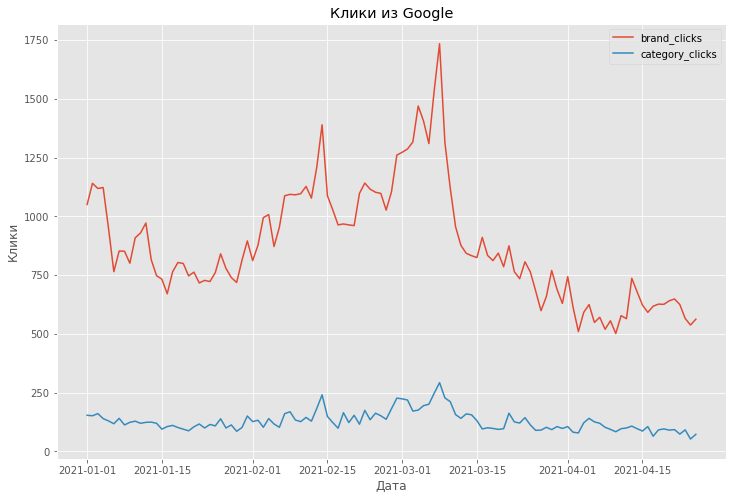

In [28]:
width = 12
height = 8
df_clicks_to_date.plot(kind='line',  figsize=(width, height))



plt.title('Клики из Google')
plt.ylabel('Клики')
plt.xlabel('Дата')

##### Вывод графика показов на категорийные и брендовые страницы по датам

Text(0.5, 0, 'Дата')

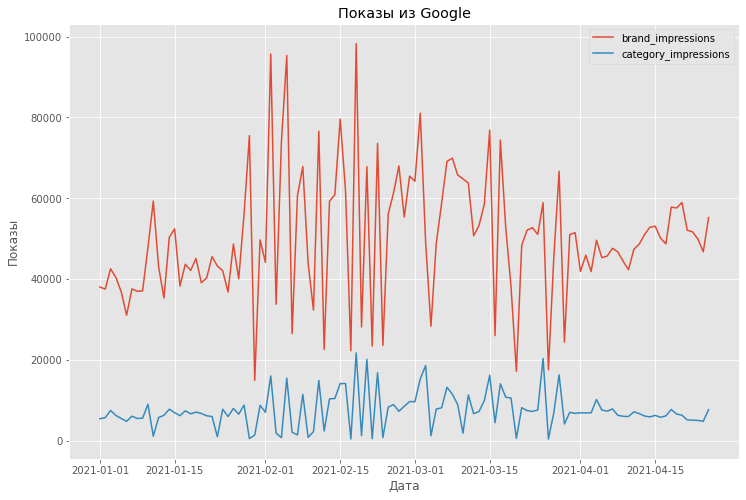

In [29]:
width = 12
height = 8
df_impressions_to_date.plot(kind='line',  figsize=(width, height))



plt.title('Показы из Google')
plt.ylabel('Показы')
plt.xlabel('Дата')

##### Вывод графика средней позиции на категорийные и брендовые страницы по датам

Text(0.5, 0, 'Дата')

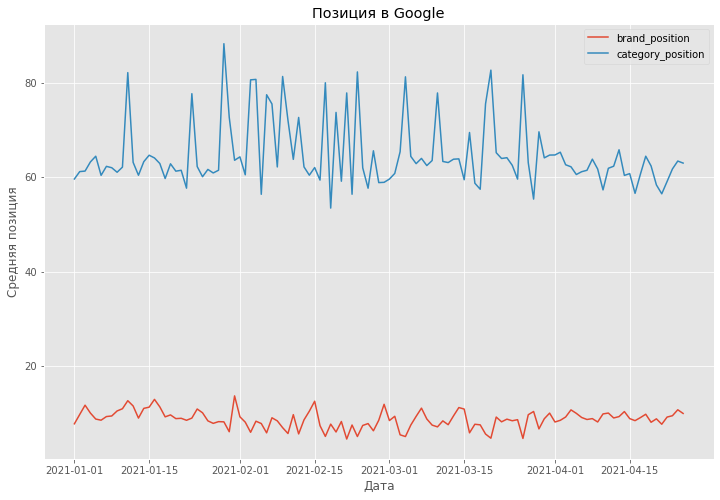

In [30]:
width = 12
height = 8
df_position_to_date.plot(kind='line',  figsize=(width, height))



plt.title('Позиция в Google')
plt.ylabel('Средняя позиция')
plt.xlabel('Дата')

##### Вывод графика среднего CTR на категорийные и брендовые страницы по датам

Text(0.5, 0, 'Дата')

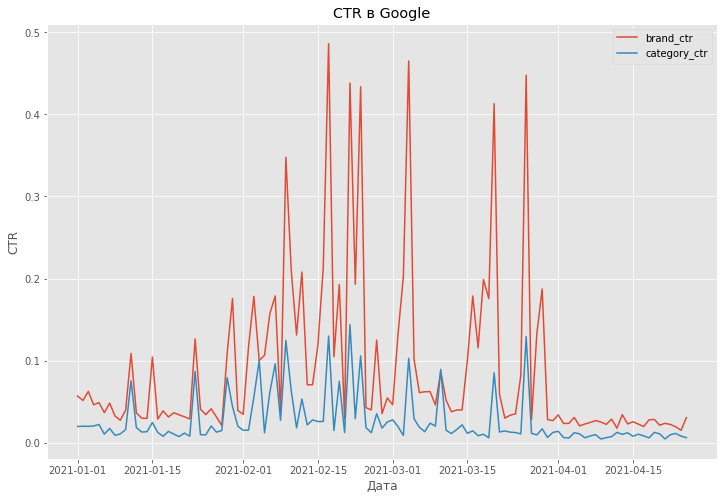

In [31]:
width = 12
height = 8
df_ctr_to_date.plot(kind='line',  figsize=(width, height))



plt.title('CTR в Google')
plt.ylabel('CTR')
plt.xlabel('Дата')

Итоговая таблица сгруппирована по бренду

In [32]:
df_clicks_to_brand = df[['name', 'brand_clicks', 'category_clicks']].groupby(['name']).sum()
df_impressions_to_brand = df[['name', 'brand_impressions', 'category_impressions']].groupby(['name']).sum()
df_position_to_brand = df[['name', 'brand_position', 'category_position']].groupby(['name']).mean()
df_ctr_to_brand = df[['name', 'brand_ctr', 'category_ctr']].groupby(['name']).mean()

In [33]:
df_clicks_to_brand = df_clicks_to_brand[(df_clicks_to_brand['brand_clicks'] > 100)\
                                        | (df_clicks_to_brand['category_clicks'] > 100)]\
                                        .sort_values('brand_clicks', ascending=False)


##### Вывод графика кликов на категорийные и брендовые страницы по брендам

Text(0.5, 0, 'Бренд')

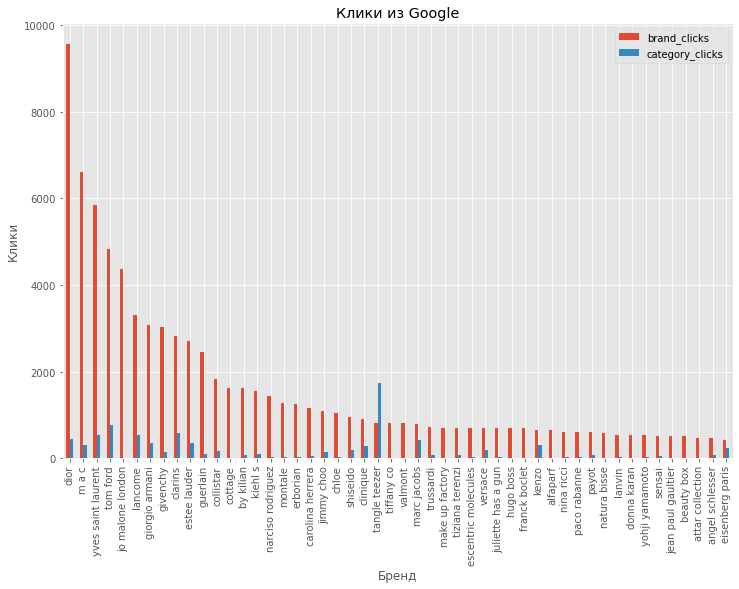

In [34]:
width = 12
height = 8
df_clicks_to_brand.head(50).plot(kind='bar',  figsize=(width, height))



plt.title('Клики из Google')
plt.ylabel('Клики')
plt.xlabel('Бренд')

In [35]:
df_impressions_to_brand = df_impressions_to_brand[(df_impressions_to_brand['brand_impressions'] > 100)\
                                        | (df_impressions_to_brand['category_impressions'] > 100)]\
                                        .sort_values('brand_impressions', ascending=False)

##### Вывод графика показов на категорийные и брендовые страницы по брендам

Text(0.5, 0, 'Бренд')

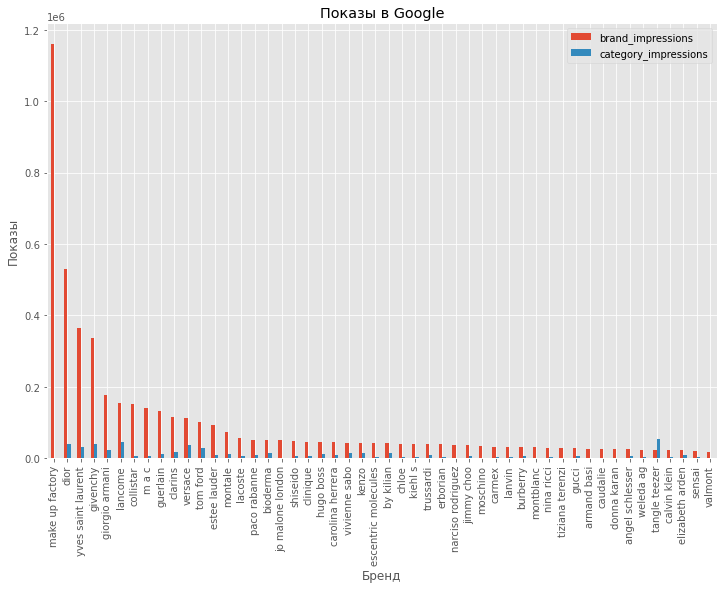

In [36]:
width = 12
height = 8
df_impressions_to_brand.head(50).plot(kind='bar',  figsize=(width, height))



plt.title('Показы в Google')
plt.ylabel('Показы')
plt.xlabel('Бренд')

In [38]:
df_position_to_brand = df_position_to_brand[df_position_to_brand['category_position']<df_position_to_brand['brand_position']]

##### Вывод графика средней позиции у категорийных и брендовых страниц во всех случаях, когда категорийная позиция выше, чем брендовая

Text(0.5, 0, 'Бренд')

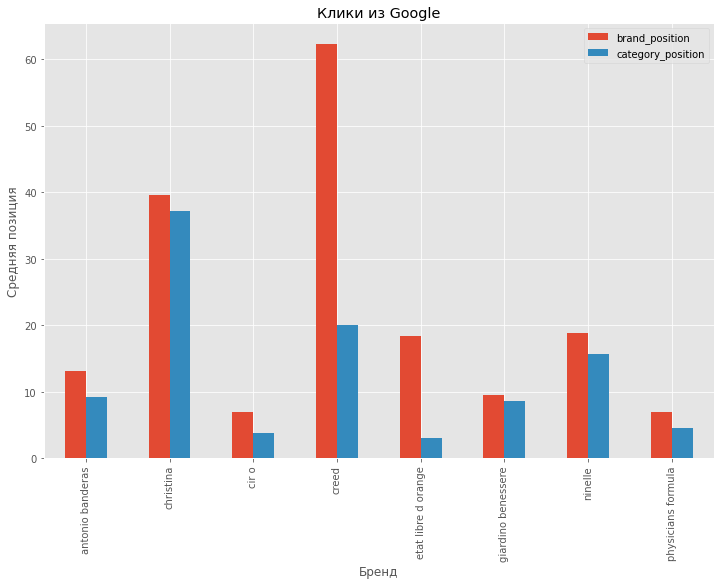

In [39]:
width = 12
height = 8
df_position_to_brand.plot(kind='bar',  figsize=(width, height))



plt.title('Клики из Google')
plt.ylabel('Средняя позиция')
plt.xlabel('Бренд')